# HOTER App: Deteksi Berita Hoaks Berbahasa Indonesia
 

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

input_path = []

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        input_path.append(path) 

display(input_path)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['/kaggle/input/indonesia-news/250 news with valid hoax label.csv',
 '/kaggle/input/indonesia-news/600 news with valid hoax label.csv',
 '/kaggle/input/indonesia-news/500_berita_indonesia.csv',
 '/kaggle/input/turnbackhoax-dataset/NEWS_content.csv',
 '/kaggle/input/ind-news/sindonews_content.csv',
 '/kaggle/input/ind-news/kompas_content.csv',
 '/kaggle/input/indonesiafalsenews/Data_uji.csv',
 '/kaggle/input/indonesiafalsenews/Data_latih.csv']

## Libraries

In [2]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import json
!pip install PySastrawi
import Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dense, Input, GlobalAveragePooling1D, LSTM, GRU
from tensorflow.keras.optimizers import Adam

     |████████████████████████████████| 210 kB 572 kB/s            


## Pemuatan Data

### Dataset dari Kaggle dan Penelitian lain

In [3]:
df250 = pd.read_csv("/kaggle/input/indonesia-news/250 news with valid hoax label.csv",
                   sep=";", encoding="ISO-8859-1")
df600 = pd.read_csv("/kaggle/input/indonesia-news/600 news with valid hoax label.csv",
                   sep=";", encoding="ISO-8859-1")
display(df600.head(), df250.head())

,berita,tagging
0,"Jakarta, Di jejaring sosial, banyak beredar in...",Valid
1,Isu bahwa ikan lele mengandung sel kanker di j...,Valid
2,Bagi penikmat kuliner dengan bahan dasar ikan ...,Valid
3,Ikan lele merupakan salah satu makanan favorit...,Valid
4,Ikan lele merupakan bahan makanan yang cukup p...,Valid


,berita,tagging
0,"Jakarta, Di jejaring sosial, banyak beredar in...",Valid
1,Isu bahwa ikan lele mengandung sel kanker di j...,Valid
2,Bagi penikmat kuliner dengan bahan dasar ikan ...,Valid
3,Ikan lele merupakan salah satu makanan favorit...,Valid
4,Ikan lele merupakan bahan makanan yang cukup p...,Valid


In [4]:
df500 = pd.read_csv("/kaggle/input/indonesia-news/500_berita_indonesia.csv", sep=";")
display(df500.head(), df500.shape)

,kategori,berita
0,valid,"""Gunung Agung erupsi untuk pertama kali pada 2..."
1,valid,"""Jakarta, CNN Indonesia -- Menteri BUMN Erick ..."
2,valid,"""Dosen Fakultas Kedokteran Hewan IPB, Yusuf Ri..."
3,valid,"""Jakarta - Dua anggota TNI, Serda N dan Serda ..."
4,valid,"""Akui Tembak Jatuh Pesawat Ukraina, Iran Tuai ..."


(500, 2)

In [5]:
indfalsenews = pd.read_csv("/kaggle/input/indonesiafalsenews/Data_latih.csv")
display(indfalsenews.head(), indfalsenews.shape)

,ID,label,tanggal,judul,narasi,nama file gambar
0,71,1,17-Aug-20,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg
1,461,1,17-Jul-20,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png
2,495,1,13-Jul-20,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png
3,550,1,8-Jul-20,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png
4,681,1,24-Jun-20,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg


(4231, 6)

### Dataset Berita Hoax: Scraping Website

In [6]:
tbh = pd.read_csv('/kaggle/input/turnbackhoax-dataset/NEWS_content.csv')
display(tbh.head(), tbh.shape)

,title,article_link,thumbnail_link,caption,date,author,page,isi_berita
0,[SALAH] Surat Pemberitahuan KPK tentang Pemblo...,https://turnbackhoax.id/2022/03/05/salah-surat...,https://turnbackhoax.id/wp-content/uploads/202...,Hasil Periksa Fakta Khairunnisa Andini. Bukan ...,"Maret 5, 2022",Admin Web,1,\n (diterjemahkan ke dalam Bahasa Indonesia) ...
1,[SALAH] Video “Gemparkan Dunia! Akibat Peran I...,https://turnbackhoax.id/2022/03/05/salah-video...,https://turnbackhoax.id/wp-content/uploads/202...,Video tersebut tidak berisi bukti damainya Rus...,"Maret 5, 2022",Adi Syafitrah,1,
2,[SALAH] Video “Indonesia mengirim bantuan Ruda...,https://turnbackhoax.id/2022/03/05/salah-video...,https://turnbackhoax.id/wp-content/uploads/202...,"Faktanya, truk dalam video yang dibagikan sumb...","Maret 5, 2022",Adi Syafitrah,1,"NATAL,,,, AMAN IMLEK,,,,,,AMAN WAISAK, AMAN N..."
3,[SALAH] “Covid-19 dinyatakan dicabut dan dinya...,https://turnbackhoax.id/2022/03/05/salah-covid...,https://turnbackhoax.id/wp-content/uploads/202...,BUKAN menyatakan Covid-19 dicabut dan tidak be...,"Maret 5, 2022",Adi Syafitrah,1,“Pesawat Rusia terbang di Ukraina semoga tida...
4,[FALSE] The “Stop Putin. #russia #ukraine #sad...,https://turnbackhoax.id/2022/03/04/false-the-s...,https://turnbackhoax.id/wp-content/uploads/202...,UNRELATED to Ukraine and it’s current conflict...,"Maret 4, 2022",Aribowo Sasmito,1,"“miris sama aturan pemerintah jaman sekarang,..."


(8555, 8)

### Dataset Berita Tepercaya: Scraping Portal Berita

In [7]:
sindo = pd.read_csv('/kaggle/input/ind-news/sindonews_content.csv')
display(sindo.head(), sindo.shape)

,title,article_link,caption,date,thumbnail_link,page,news_content
0,Update: Hari Ini Positif Covid-19 Bertambah 24...,https://nasional.sindonews.com/read/704643/15/...,Dilaporkan juga kasus yang sembuh dari Covid-1...,"Minggu, 06 Maret 2022 - 17:06 WIB",https://pict-c.sindonews.net/dyn/180/pena/news...,0,Kasus positif Covid-19 di Indonesia pada Min...
1,"Prabowo Terlempar dari 3 Besar, Sandiaga Uno C...",https://nasional.sindonews.com/read/704637/12/...,dalam survei Key Opinion Leader yang digelar P...,"Minggu, 06 Maret 2022 - 16:56 WIB",https://pict-c.sindonews.net/dyn/180/pena/news...,0,Menteri Pertahanan (Menhan) yang juga Ketua Um...
2,2 Penyebab Puan Maharani Selalu di Urutan Terb...,https://nasional.sindonews.com/read/704617/12/...,"Sebagai ketua DPR, Puan Maharani dianggap jara...","Minggu, 06 Maret 2022 - 16:33 WIB",https://pict-c.sindonews.net/dyn/180/pena/news...,0,Ketua DPR RI Puan Maharani konsisten menjadi...
3,Dave Laksono Sarankan Indonesia Ambil Inisiati...,https://nasional.sindonews.com/read/704591/12/...,Dave juga terus mendorong Indonesia untuk memb...,"Minggu, 06 Maret 2022 - 15:39 WIB",https://pict-c.sindonews.net/dyn/180/pena/news...,0,Ukraina mengirim surat terbuka untuk Indonesia...
4,Dubes Ukraina Tulis Surat Terbuka untuk Jokowi...,https://nasional.sindonews.com/read/704585/15/...,Duta Besar Dr Vasyl Hamianin secara terbuka me...,"Minggu, 06 Maret 2022 - 15:25 WIB",https://pict-c.sindonews.net/dyn/180/pena/news...,0,Duta Besar Ukraina Dr Vasyl Hamianin menulis...


(1500, 7)

In [8]:
kompas = pd.read_csv('/kaggle/input/ind-news/kompas_content.csv')
display(kompas.head(), kompas.shape)

,title,article_link,category,date,thumbnail_link,page,news_content
0,"Yusril: Sesuai Pandangan Jokowi, Usul Penundaa...",https://nasional.kompas.com/read/2022/03/06/16...,Nasional,"06/03/2022, 16:25",https://asset.kompas.com/crops/XjGvW5uwn4EYu72...,1,Ahli hukum tata negara Yusril Ihza Mahendra me...
1,Yusril: Penundaan Pemilu 2024 Bisa Timbulkan A...,https://nasional.kompas.com/read/2022/03/06/16...,Nasional,"06/03/2022, 16:05",https://asset.kompas.com/crops/XjGvW5uwn4EYu72...,1,Ahli hukum tata negara Yusril Ihza Mahendra me...
2,Pemerintah Pastikan Percepat Proses Operasiona...,https://nasional.kompas.com/read/2022/03/06/15...,Nasional,"06/03/2022, 15:50",https://asset.kompas.com/crops/L3WHZXrjHI_D9ED...,1,Tenaga Ahli Utama Kantor Staf Presiden Wandy T...
3,Jokowi Diminta Tak Biarkan Bola Liar Isu Perpa...,https://nasional.kompas.com/read/2022/03/06/15...,Nasional,"06/03/2022, 15:16",https://asset.kompas.com/crops/Gob16Gn8oMeqSxD...,1,Guru Besar Universitas Islam Negeri (UIN) Syar...
4,Kopi yang Mengandung Paracetamol Beredar di Pa...,https://nasional.kompas.com/read/2022/03/06/14...,Nasional,"06/03/2022, 14:48",https://asset.kompas.com/crops/hCM5PfIEbXscfZn...,1,Badan Pengawas Obat dan Makanan (BPOM) mengimb...


(1500, 7)

## Pembersihan Data

### Membuang kolom yang tidak diperlukan dan memberikan label

In [9]:
#indfalsenews
del indfalsenews['ID']
del indfalsenews['nama file gambar']
del indfalsenews['tanggal']
indfalsenews["label"].replace({1:"tepercaya", 0:"hoaks"}, inplace=True)
indfalsenews.head()

,label,judul,narasi
0,tepercaya,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...
1,tepercaya,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...
2,tepercaya,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...
3,tepercaya,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k..."
4,tepercaya,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .


In [10]:
# df 250 & 600
df_con = pd.concat([df250, df600], ignore_index=True)
df_con = df_con[~df_con.duplicated()]
df_con.columns = ['narasi', 'label']
df_con["label"].replace({"Valid":"tepercaya", "Hoax":"hoaks"}, inplace=True)
display(df_con.head(), df_con.shape)

,narasi,label
0,"Jakarta, Di jejaring sosial, banyak beredar in...",tepercaya
1,Isu bahwa ikan lele mengandung sel kanker di j...,tepercaya
2,Bagi penikmat kuliner dengan bahan dasar ikan ...,tepercaya
3,Ikan lele merupakan salah satu makanan favorit...,tepercaya
4,Ikan lele merupakan bahan makanan yang cukup p...,tepercaya


(601, 2)

In [11]:
# df 500
df500.columns = ['label', 'narasi']
df500 = df500[['narasi', 'label']]
df500["label"].replace({"valid":"tepercaya", "hoax":"hoaks"}, inplace=True)

df_con = pd.concat([df_con, df500], ignore_index=True)
df_con = df_con[~df_con.duplicated()]
display(df_con.head(), df_con.shape)

,narasi,label
0,"Jakarta, Di jejaring sosial, banyak beredar in...",tepercaya
1,Isu bahwa ikan lele mengandung sel kanker di j...,tepercaya
2,Bagi penikmat kuliner dengan bahan dasar ikan ...,tepercaya
3,Ikan lele merupakan salah satu makanan favorit...,tepercaya
4,Ikan lele merupakan bahan makanan yang cukup p...,tepercaya


(1084, 2)

In [12]:
# sindonews
sindo = sindo[['title', 'news_content']]
sindo.dropna(inplace=True)
sindo['label'] = 'tepercaya'
sindo.columns = ['judul', 'narasi', 'label']
display(sindo.head(), sindo.shape)

,judul,narasi,label
0,Update: Hari Ini Positif Covid-19 Bertambah 24...,Kasus positif Covid-19 di Indonesia pada Min...,tepercaya
1,"Prabowo Terlempar dari 3 Besar, Sandiaga Uno C...",Menteri Pertahanan (Menhan) yang juga Ketua Um...,tepercaya
2,2 Penyebab Puan Maharani Selalu di Urutan Terb...,Ketua DPR RI Puan Maharani konsisten menjadi...,tepercaya
3,Dave Laksono Sarankan Indonesia Ambil Inisiati...,Ukraina mengirim surat terbuka untuk Indonesia...,tepercaya
4,Dubes Ukraina Tulis Surat Terbuka untuk Jokowi...,Duta Besar Ukraina Dr Vasyl Hamianin menulis...,tepercaya


(1498, 3)

In [13]:
# kompas
kompas = kompas[['title', 'news_content']]
kompas.dropna(inplace=True)
kompas['label'] = 'tepercaya'
kompas.columns = ['judul', 'narasi', 'label']
display(kompas.head(), kompas.shape)

,judul,narasi,label
0,"Yusril: Sesuai Pandangan Jokowi, Usul Penundaa...",Ahli hukum tata negara Yusril Ihza Mahendra me...,tepercaya
1,Yusril: Penundaan Pemilu 2024 Bisa Timbulkan A...,Ahli hukum tata negara Yusril Ihza Mahendra me...,tepercaya
2,Pemerintah Pastikan Percepat Proses Operasiona...,Tenaga Ahli Utama Kantor Staf Presiden Wandy T...,tepercaya
3,Jokowi Diminta Tak Biarkan Bola Liar Isu Perpa...,Guru Besar Universitas Islam Negeri (UIN) Syar...,tepercaya
4,Kopi yang Mengandung Paracetamol Beredar di Pa...,Badan Pengawas Obat dan Makanan (BPOM) mengimb...,tepercaya


(1500, 3)

In [14]:
# turnbackhoax
tbh = tbh[['title', 'isi_berita']]
tbh.columns = ['judul', 'narasi']
tbh['label'] = "hoaks"
tbh.head()

,judul,narasi,label
0,[SALAH] Surat Pemberitahuan KPK tentang Pemblo...,\n (diterjemahkan ke dalam Bahasa Indonesia) ...,hoaks
1,[SALAH] Video “Gemparkan Dunia! Akibat Peran I...,,hoaks
2,[SALAH] Video “Indonesia mengirim bantuan Ruda...,"NATAL,,,, AMAN IMLEK,,,,,,AMAN WAISAK, AMAN N...",hoaks
3,[SALAH] “Covid-19 dinyatakan dicabut dan dinya...,“Pesawat Rusia terbang di Ukraina semoga tida...,hoaks
4,[FALSE] The “Stop Putin. #russia #ukraine #sad...,"“miris sama aturan pemerintah jaman sekarang,...",hoaks


### Gabung semua dataset

In [15]:
berita = pd.concat([sindo, tbh, kompas, indfalsenews, df_con], ignore_index=True)
berita = berita[['judul', 'narasi', 'label']]
berita.fillna(" ", inplace=True)
display(berita.head(), berita.shape)

,judul,narasi,label
0,Update: Hari Ini Positif Covid-19 Bertambah 24...,Kasus positif Covid-19 di Indonesia pada Min...,tepercaya
1,"Prabowo Terlempar dari 3 Besar, Sandiaga Uno C...",Menteri Pertahanan (Menhan) yang juga Ketua Um...,tepercaya
2,2 Penyebab Puan Maharani Selalu di Urutan Terb...,Ketua DPR RI Puan Maharani konsisten menjadi...,tepercaya
3,Dave Laksono Sarankan Indonesia Ambil Inisiati...,Ukraina mengirim surat terbuka untuk Indonesia...,tepercaya
4,Dubes Ukraina Tulis Surat Terbuka untuk Jokowi...,Duta Besar Ukraina Dr Vasyl Hamianin menulis...,tepercaya


(16868, 3)

### Fungsi pembersihan data untuk EDA dan Pra-pemrosesan Data

In [16]:
### Clean function

# stemmer from sastrawi
stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()

def clean_text(text):
    text = text.strip() # remove whitespace
    text = re.sub('\[.*?\]', ' ', text) # remove text in square brackets
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuation
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub('http\S+|\S+\.com\S+|bit.ly\S+', '', text) # remove url
    text = re.sub(r'\@\S+', '', text) # remove mention
    text = re.sub('[‘’“”…]', '', text) # remove other punctuation
    text = text.lower() # convert to lowercase
    text = stemmer.stem(text) # stemming
    text = text.strip() # remove whitespace
    return text

In [17]:
### stopwords and stemmer

# stopwords from nltk
try:
  stop_words = set(stopwords.words("indonesian"))
except:
  nltk.download('stopwords')
  stop_words = set(stopwords.words("indonesian"))

# stopwords from sastrawi
sw_factory = StopWordRemoverFactory()
stop_words_sastrawi = sw_factory.create_stop_word_remover()

more_stopword = [] # utk custom stopword

# remove the stopwords and single-character words
def remove_sw_and_sc(text):
    final_text = []
    for i in text.split():
        if i.strip() not in stop_words and len(i) > 1: # remove single-character words
            final_text.append(i.strip())
    return " ".join(final_text)

# create function
def remove_stopwords(text):
    text = remove_sw_and_sc(text) # stopwords nltk
    text = stop_words_sastrawi.remove(text) # stopwords Sastrawi
    return text

## EDA

### Berita tepercaya

In [18]:
# menggabung judul dan isi berita
tepercaya = berita[berita.label == "tepercaya"]
tepercaya['konten'] = tepercaya['judul'] + " " + tepercaya["narasi"]
tepercaya = " ".join(tepercaya['konten'].values.tolist())
tepercaya[-500:], len(tepercaya)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


('s karena ledakan bom bunuh diri di Polrestabes Medan, dan dua orang tewas karena melawan polisi saat akan ditangkap. Para terduga teroris itu ditangkap di berbagai daerah yakni di Pekanbaru, Riau sebanyak lima orang, di Jabodetabek tiga orang, di Banten lima orang, di Jawa Tengah 11 orang, di Jawa Timur dua orang, dan di Jawa Barat 11 orang.Sementara di wilayah Medan, Densus 88 menangkap 30 orang terduga teroris, di Kalimantan satu orang, di Aceh empat orang, dan di Sulawesi Selatan satu orang."',
 10571738)

In [19]:
# menerapkan fungsi pembersihan data
tepercaya = clean_text(tepercaya)
tepercaya = remove_stopwords(tepercaya)
tepercaya[:500]

'update positif positif indonesia minggu maret akumulasi positif hasil tracing periksa spesimen metode real time polymerase chain reaction pcr tes cepat molekuler tcm baca update maret positif tinggal lapor sembuh catat total sembuh tinggal total tinggal orangsebelumnya total akumulasi positif indonesia sabtu maret sembuh total sembuh total tinggal orangdata positif indonesia publikasi menteri sehat kemenkes laman prabowo lempar sandiaga uno capres charming menteri tahan menhan ketua partai gerin'

In [20]:
# mengekstrak kata dari seluruh isi data string
tepercaya_tokens = word_tokenize(tepercaya)
print(tepercaya_tokens[:100])

['update', 'positif', 'positif', 'indonesia', 'minggu', 'maret', 'akumulasi', 'positif', 'hasil', 'tracing', 'periksa', 'spesimen', 'metode', 'real', 'time', 'polymerase', 'chain', 'reaction', 'pcr', 'tes', 'cepat', 'molekuler', 'tcm', 'baca', 'update', 'maret', 'positif', 'tinggal', 'lapor', 'sembuh', 'catat', 'total', 'sembuh', 'tinggal', 'total', 'tinggal', 'orangsebelumnya', 'total', 'akumulasi', 'positif', 'indonesia', 'sabtu', 'maret', 'sembuh', 'total', 'sembuh', 'total', 'tinggal', 'orangdata', 'positif', 'indonesia', 'publikasi', 'menteri', 'sehat', 'kemenkes', 'laman', 'prabowo', 'lempar', 'sandiaga', 'uno', 'capres', 'charming', 'menteri', 'tahan', 'menhan', 'ketua', 'partai', 'gerindra', 'prabowo', 'subianto', 'nama', 'calon', 'presiden', 'capres', 'survei', 'opini', 'publik', 'survei', 'key', 'opinion', 'leader', 'gelar', 'politika', 'research', 'consulting', 'prc', 'parameter', 'politik', 'indonesia', 'ppi', 'prabowo', 'singkir', 'posisi', 'besarsecara', 'hasil', 'survei'

In [21]:
# frekuensi kata
freq_tepercaya = nltk.FreqDist(tepercaya_tokens)
print(freq_tepercaya.most_common(50))

[('indonesia', 6836), ('presiden', 5495), ('baca', 5334), ('perintah', 4694), ('negara', 4009), ('masyarakat', 3987), ('jokowi', 3902), ('milu', 3574), ('partai', 3457), ('menteri', 2897), ('milik', 2747), ('persen', 2631), ('kait', 2546), ('kota', 2490), ('tni', 2483), ('ketua', 2440), ('jabat', 2398), ('atur', 2392), ('jakarta', 2292), ('hukum', 2259), ('politik', 2225), ('hasil', 2216), ('jalan', 2172), ('kepala', 2150), ('bangun', 2113), ('pilih', 2106), ('tunda', 2010), ('sehat', 1995), ('dpr', 1944), ('salah', 1935), ('daerah', 1908), ('tingkat', 1902), ('kpk', 1862), ('terima', 1801), ('duga', 1773), ('nomor', 1757), ('anggota', 1733), ('nilai', 1716), ('kabupaten', 1712), ('dasar', 1686), ('tahan', 1679), ('nasional', 1671), ('ikn', 1670), ('korupsi', 1651), ('wakil', 1642), ('dukung', 1640), ('pasal', 1634), ('lapor', 1610), ('temu', 1596), ('tindak', 1589)]


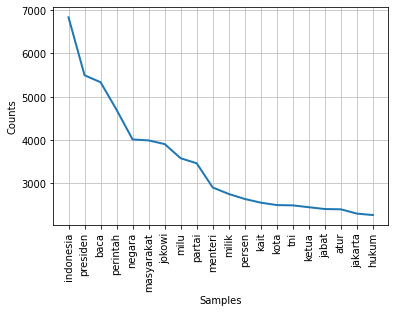

In [22]:
# plot frekuensi kata
freq_tepercaya.plot(20)

In [23]:
# menambah stopwords yang tidak tersortir oleh funngsi pembersihan data
stop_factory = StopWordRemoverFactory().get_stop_words() # load default stopword
more_stopword += ['yg', 'milik', 'the', 'baca', 'indonesia'] # menambahkan stopword
data = stop_factory + more_stopword # menggabungkan stopword
 
dictionary = ArrayDictionary(data)
stop_words_sastrawi = StopWordRemover(dictionary)

tepercaya = stop_words_sastrawi.remove(tepercaya)

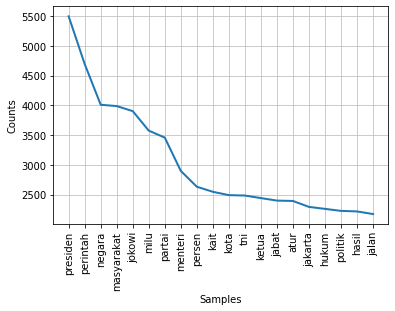

In [24]:
# melihat kembali plot frekuensi kata
tepercaya_tokens = word_tokenize(tepercaya)
freq_tepercaya = nltk.FreqDist(tepercaya_tokens)
freq_tepercaya.plot(20)

### Berita hoaks

In [25]:
# menggabung judul dan isi berita
hoaks = berita[berita.label == "hoaks"]
hoaks['konten'] = hoaks['judul'] + " " + hoaks["narasi"]
hoaks = " ".join(hoaks['konten'].values.tolist())
hoaks[-500:], len(hoaks)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


('o sekarang nerusin tol yg ada itu hanya penambahan. Jangan merasa bpk pembangunan dik jokowi. Krna bapak pembnguann masih melekat dihati rakyat adalah almarhum HM SOEHARTO Bkn yg lain. Ayo bersatu kmbali dukung no 2. PRABOWO SANDI”   "Perhatian untuk seluruh anggota, infokan ke semua keluarga dan kerabat bila melihat serangga seperti dalam foto, jangan sekali - kali menyentuhnya, di Thailand telah ditemukan serangga ini dalam jumlah besar, di Myanmar juga ditemukan, dan sudah masuk ke Indonesia"',
 7141528)

In [26]:
# menerapkan fungsi pembersihan data
hoaks = clean_text(hoaks)
hoaks = remove_stopwords(hoaks)
hoaks[:500]

'surat pemberitahuan kpk blokir rekening terjemah bahasa komisi berantas korupsi kpk lembaga perintah bentuk tingkat efektivitas efisiensi usaha berantas korupsi kpk lembaga independen bebas pengaruh jalan tugas narasi referensi komisi tugas tanggungjawabnya dasar undang undang republik nomor tentah komisi berantas korupsi laksana tugas komisi pegang teguh prinsip utama atur hukum transparansi akuntabilitas proporsionalitas komisi tanggung publik lapor presiden dpr bpk informasi kpk terima inform'

In [27]:
# mengekstrak kata dari seluruh isi data string
hoaks_tokens = word_tokenize(hoaks)
print(hoaks_tokens[:100])

['surat', 'pemberitahuan', 'kpk', 'blokir', 'rekening', 'terjemah', 'bahasa', 'komisi', 'berantas', 'korupsi', 'kpk', 'lembaga', 'perintah', 'bentuk', 'tingkat', 'efektivitas', 'efisiensi', 'usaha', 'berantas', 'korupsi', 'kpk', 'lembaga', 'independen', 'bebas', 'pengaruh', 'jalan', 'tugas', 'narasi', 'referensi', 'komisi', 'tugas', 'tanggungjawabnya', 'dasar', 'undang', 'undang', 'republik', 'nomor', 'tentah', 'komisi', 'berantas', 'korupsi', 'laksana', 'tugas', 'komisi', 'pegang', 'teguh', 'prinsip', 'utama', 'atur', 'hukum', 'transparansi', 'akuntabilitas', 'proporsionalitas', 'komisi', 'tanggung', 'publik', 'lapor', 'presiden', 'dpr', 'bpk', 'informasi', 'kpk', 'terima', 'informasi', 'kait', 'bayar', 'tujuh', 'ratus', 'juta', 'dolar', 'amerika', 'serikat', 'rekening', 'blokir', 'rekening', 'wajib', 'bayar', 'sesuai', 'dana', 'sita', 'dana', 'bayar', 'tujuh', 'juta', 'rupiah', 'idr', 'izin', 'dana', 'dana', 'sita', 'jamin', 'terima', 'dana', 'rekening', 'blokir', 'terima', 'bayar', 

In [28]:
# frekuensi kata
freq_hoaks = nltk.FreqDist(hoaks_tokens)
print(freq_hoaks.most_common(50))

[('foto', 2839), ('video', 2358), ('salah', 2337), ('informasi', 2068), ('jokowi', 2015), ('akun', 1841), ('jakarta', 1818), ('presiden', 1777), ('berita', 1669), ('negara', 1646), ('perintah', 1479), ('konten', 1457), ('narasi', 1446), ('anak', 1440), ('hasil', 1424), ('facebook', 1395), ('tulis', 1394), ('makan', 1361), ('nama', 1334), ('buah', 1328), ('jalan', 1322), ('edar', 1276), ('of', 1268), ('air', 1230), ('tinggal', 1223), ('media', 1208), ('gambar', 1193), ('virus', 1189), ('hoax', 1177), ('islam', 1151), ('warga', 1146), ('rumah', 1146), ('sakit', 1129), ('kait', 1098), ('masyarakat', 1079), ('temu', 1070), ('polisi', 1050), ('china', 1034), ('dunia', 1033), ('bantu', 1033), ('sebar', 1027), ('to', 1025), ('menteri', 1023), ('lengkap', 1023), ('terima', 1015), ('referensi', 1013), ('and', 971), ('in', 959), ('pesan', 954), ('vaksin', 932)]


In [29]:
# simpan distribusi kata hoaks di json
# akan digunakan pada website aplikasi
dist_kata = dict(freq_hoaks)

with open('dist_kata_hoaks.json', 'w') as fp:
    json.dump(dist_kata, fp,  indent=4)

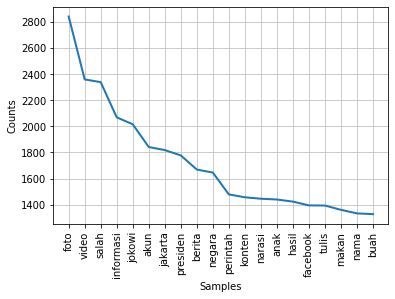

In [30]:
# plot frekuensi kata
freq_hoaks.plot(20)

In [31]:
# menambahkan stopword baru
stop_factory = StopWordRemoverFactory().get_stop_words() # load default stopword

more_stopword += ['foto', 'video', 'salah', 'akun', 'facebook', 'of', 'to', 'hoax', 'and', 'in']
data = stop_factory + more_stopword # menggabungkan stopword
 
dictionary = ArrayDictionary(data)
stop_words_sastrawi = StopWordRemover(dictionary)

tepercaya = stop_words_sastrawi.remove(hoaks)

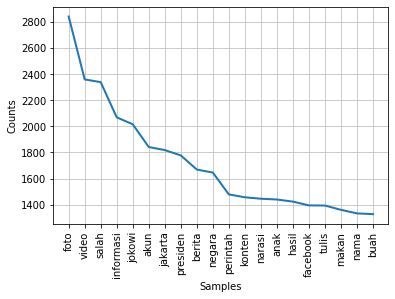

In [32]:
hoaks_tokens = word_tokenize(hoaks)
freq_hoaks = nltk.FreqDist(hoaks_tokens)
freq_hoaks.plot(20)

### Data secara keseluruhan

In [33]:
# gabungkan judul dan isi berita
narasi = pd.DataFrame()
narasi['content'] = berita['judul'] + " " + berita["narasi"]
narasi['label'] = berita['label']

In [34]:
display(narasi.head(), narasi.shape)

,content,label
0,Update: Hari Ini Positif Covid-19 Bertambah 24...,tepercaya
1,"Prabowo Terlempar dari 3 Besar, Sandiaga Uno C...",tepercaya
2,2 Penyebab Puan Maharani Selalu di Urutan Terb...,tepercaya
3,Dave Laksono Sarankan Indonesia Ambil Inisiati...,tepercaya
4,Dubes Ukraina Tulis Surat Terbuka untuk Jokowi...,tepercaya


(16868, 2)

In [35]:
# Uppercase
narasi['upper'] = narasi['content'].apply(lambda x: len([x for x in x.split() if x.isupper() and (len(x) > 1)]))
narasi[['content','upper']].head()

,content,upper
0,Update: Hari Ini Positif Covid-19 Bertambah 24...,2
1,"Prabowo Terlempar dari 3 Besar, Sandiaga Uno C...",11
2,2 Penyebab Puan Maharani Selalu di Urutan Terb...,6
3,Dave Laksono Sarankan Indonesia Ambil Inisiati...,4
4,Dubes Ukraina Tulis Surat Terbuka untuk Jokowi...,2


In [36]:
# Lowercase
narasi['lower'] = narasi['content'].apply(lambda x: len([x for x in x.split() if x.islower()]))
narasi[['content','lower']].head()

,content,lower
0,Update: Hari Ini Positif Covid-19 Bertambah 24...,85
1,"Prabowo Terlempar dari 3 Besar, Sandiaga Uno C...",349
2,2 Penyebab Puan Maharani Selalu di Urutan Terb...,342
3,Dave Laksono Sarankan Indonesia Ambil Inisiati...,201
4,Dubes Ukraina Tulis Surat Terbuka untuk Jokowi...,583


In [37]:
# Punctuation
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return count

narasi['punctuation'] = narasi['content'].apply(lambda x: count_punct(x))
narasi[['content','punctuation']].head()

,content,punctuation
0,Update: Hari Ini Positif Covid-19 Bertambah 24...,55
1,"Prabowo Terlempar dari 3 Besar, Sandiaga Uno C...",183
2,2 Penyebab Puan Maharani Selalu di Urutan Terb...,86
3,Dave Laksono Sarankan Indonesia Ambil Inisiati...,51
4,Dubes Ukraina Tulis Surat Terbuka untuk Jokowi...,120


In [38]:
# Hashtag
narasi['hastags'] = narasi['content'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
narasi[['content','hastags']].head()

,content,hastags
0,Update: Hari Ini Positif Covid-19 Bertambah 24...,0
1,"Prabowo Terlempar dari 3 Besar, Sandiaga Uno C...",0
2,2 Penyebab Puan Maharani Selalu di Urutan Terb...,0
3,Dave Laksono Sarankan Indonesia Ambil Inisiati...,0
4,Dubes Ukraina Tulis Surat Terbuka untuk Jokowi...,0


In [39]:
# Numbers / Digits
narasi['numerics'] = narasi['content'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
narasi[['content','numerics']].head()

,content,numerics
0,Update: Hari Ini Positif Covid-19 Bertambah 24...,7
1,"Prabowo Terlempar dari 3 Besar, Sandiaga Uno C...",13
2,2 Penyebab Puan Maharani Selalu di Urutan Terb...,9
3,Dave Laksono Sarankan Indonesia Ambil Inisiati...,2
4,Dubes Ukraina Tulis Surat Terbuka untuk Jokowi...,1


In [40]:
# apply clean function on review column
# belum hapus stopwords
narasi['content'] = narasi['content'].apply(clean_text)

In [41]:
# Number of Words
narasi['word_count'] = narasi['content'].apply(lambda x: len(str(x).split(" ")))
narasi[['content','word_count']].head()

,content,word_count
0,update hari ini positif tambah kasus kasus pos...,118
1,prabowo lempar dari besar sandiaga uno capres ...,508
2,sebab puan maharani selalu di urut bawah surve...,449
3,dave laksono saran indonesia ambil inisiatif d...,269
4,dubes ukraina tulis surat buka untuk jokowi ap...,773


In [42]:
# Number of Character
narasi['char_count'] = narasi['content'].str.len()
narasi[['content','char_count']].head()

,content,char_count
0,update hari ini positif tambah kasus kasus pos...,778
1,prabowo lempar dari besar sandiaga uno capres ...,3226
2,sebab puan maharani selalu di urut bawah surve...,2870
3,dave laksono saran indonesia ambil inisiatif d...,1697
4,dubes ukraina tulis surat buka untuk jokowi ap...,4915


In [43]:
# Average Words
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/(len(words)+0.000001))

narasi['avg_word'] = narasi['content'].apply(lambda x: avg_word(x)).round(1)
narasi[['content','avg_word']].head()

,content,avg_word
0,update hari ini positif tambah kasus kasus pos...,5.6
1,prabowo lempar dari besar sandiaga uno capres ...,5.4
2,sebab puan maharani selalu di urut bawah surve...,5.4
3,dave laksono saran indonesia ambil inisiatif d...,5.3
4,dubes ukraina tulis surat buka untuk jokowi ap...,5.4


In [44]:
narasi.head()

,content,label,upper,lower,punctuation,hastags,numerics,word_count,char_count,avg_word
0,update hari ini positif tambah kasus kasus pos...,tepercaya,2,85,55,0,7,118,778,5.6
1,prabowo lempar dari besar sandiaga uno capres ...,tepercaya,11,349,183,0,13,508,3226,5.4
2,sebab puan maharani selalu di urut bawah surve...,tepercaya,6,342,86,0,9,449,2870,5.4
3,dave laksono saran indonesia ambil inisiatif d...,tepercaya,4,201,51,0,2,269,1697,5.3
4,dubes ukraina tulis surat buka untuk jokowi ap...,tepercaya,2,583,120,0,1,773,4915,5.4


In [45]:
narasi[narasi.label=='tepercaya'].describe()

,upper,lower,punctuation,hastags,numerics,word_count,char_count,avg_word
count,7081.000000,7081.000000,7081.000000,7081.000000,7081.000000,7081.000000,7081.000000,7081.000000
mean,7.836605,132.292473,41.014546,0.069058,3.301935,196.181048,1237.559667,5.245078
std,10.961050,157.571469,47.290901,0.517659,5.509961,216.787502,1385.046598,0.453077
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,19.000000,2.100000
25%,1.000000,14.000000,4.000000,0.000000,0.000000,28.000000,174.000000,5.000000
50%,4.000000,69.000000,21.000000,0.000000,1.000000,101.000000,616.000000,5.200000
75%,11.000000,208.000000,66.000000,0.000000,4.000000,309.000000,1948.000000,5.500000
max,161.000000,1577.000000,604.000000,21.000000,62.000000,2015.000000,13027.000000,10.700000


In [46]:
narasi[narasi.label=='hoaks'].describe()

,upper,lower,punctuation,hastags,numerics,word_count,char_count,avg_word
count,9787.000000,9787.000000,9787.000000,9787.000000,9787.000000,9787.000000,9787.000000,9787.000000
mean,7.133851,61.942066,26.620926,0.222234,1.314294,93.798917,577.717789,5.233442
std,18.862407,147.637283,49.190144,1.429652,3.485147,194.292841,1202.138660,0.559644
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,2.100000
25%,1.000000,4.000000,5.000000,0.000000,0.000000,18.000000,108.000000,4.900000
50%,3.000000,19.000000,12.000000,0.000000,0.000000,38.000000,234.000000,5.200000
75%,7.000000,51.000000,27.000000,0.000000,1.000000,82.000000,502.000000,5.500000
max,1339.000000,4023.000000,905.000000,62.000000,85.000000,4524.000000,28415.000000,10.800000


In [47]:
stat_df = narasi.groupby(['label']).agg(['count', 'max', 'min', 'mean']).word_count.T
stat_df

label,hoaks,tepercaya
count,9787.000000,7081.000000
max,4524.000000,2015.000000
min,1.000000,2.000000
mean,93.798917,196.181048


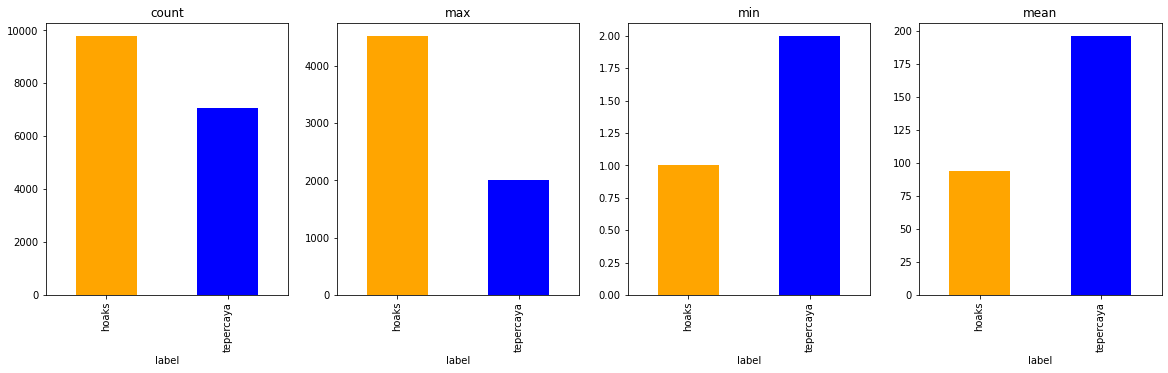

In [48]:
plt.figure(figsize=(20,5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    stat_df.iloc[i].plot.bar(color=['orange', 'blue'])
    plt.title(stat_df.iloc[i].name)
plt.show()

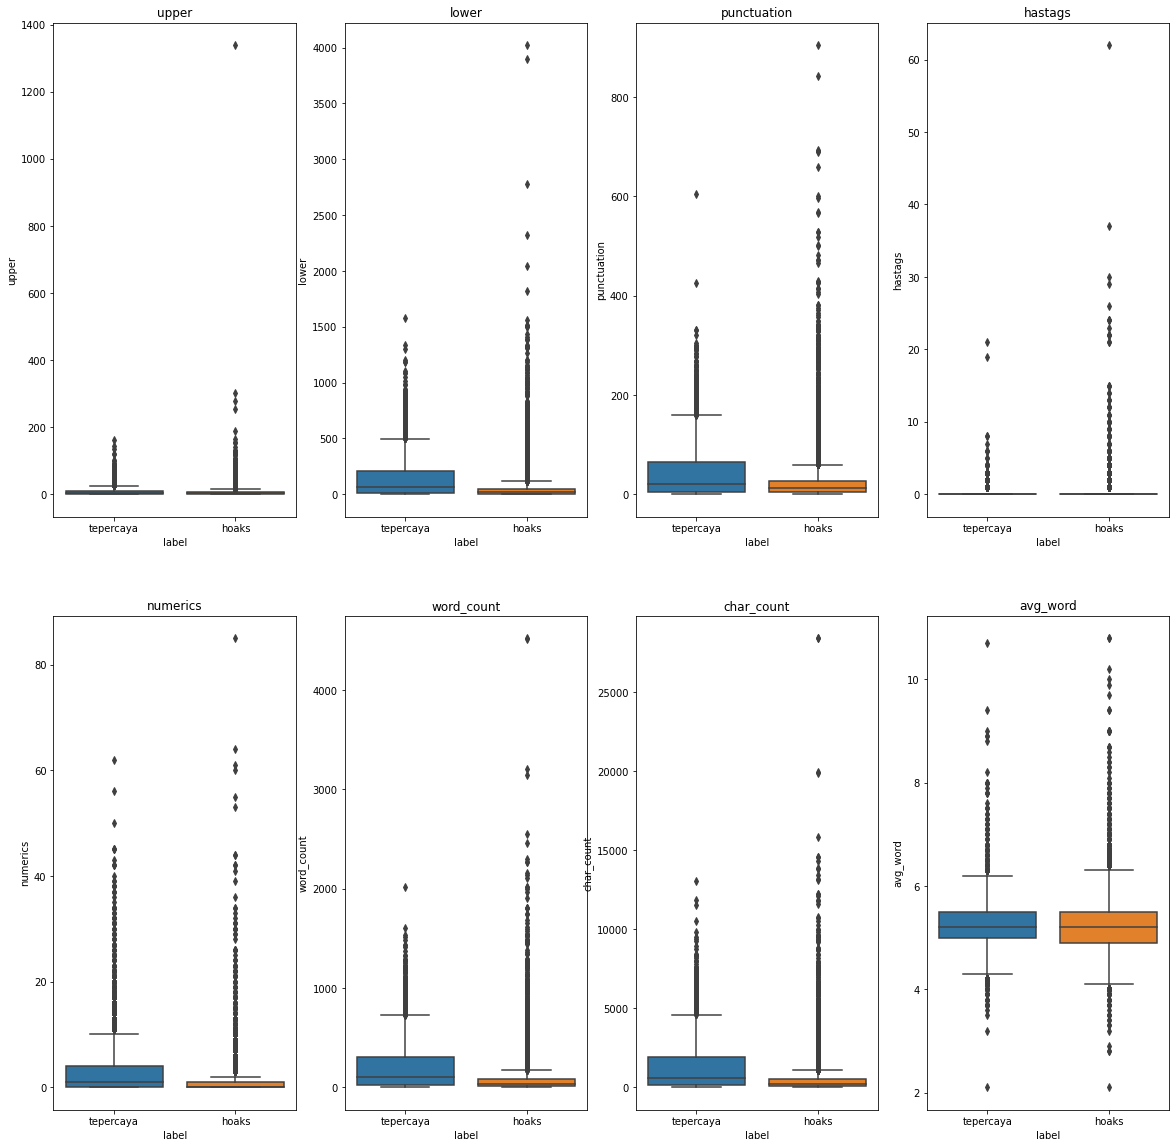

In [49]:
# boxplot dengan pencilan
num_columns = narasi.columns[2:]

plt.figure(figsize=(20, 20))
for ind, col in enumerate(num_columns):
    plt.subplot(2, 4, ind+1)
    sns.boxplot(data=narasi, y=col, x='label')
    plt.title(col)
plt.show()

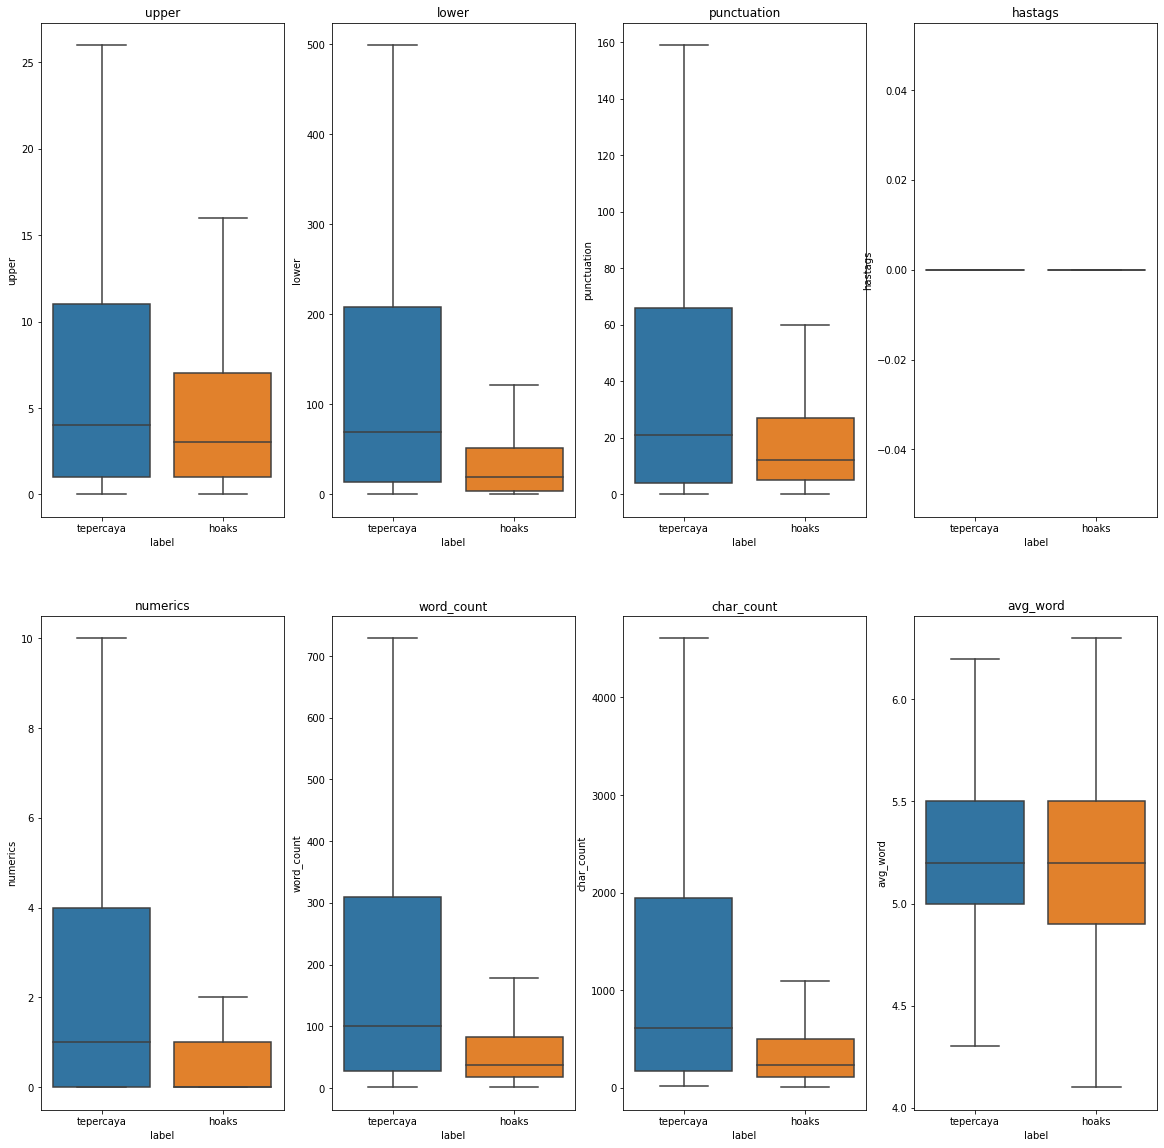

In [50]:
# boxplot dengan pencilan
num_columns = narasi.columns[2:]

plt.figure(figsize=(20, 20))
for ind, col in enumerate(num_columns):
    plt.subplot(2, 4, ind+1)
    sns.boxplot(data=narasi, y=col, x='label', showfliers = False)
    plt.title(col)
plt.show()

In [51]:
# remove stopwords
narasi['content'] = narasi['content'].apply(remove_stopwords)

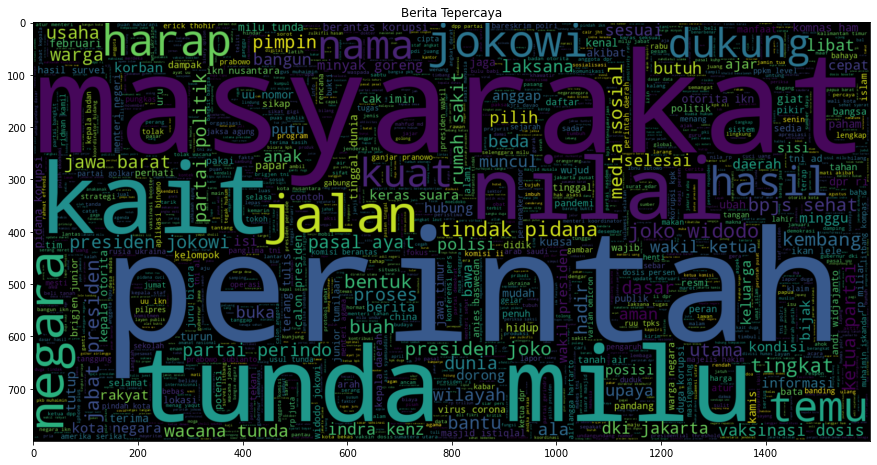

In [52]:
# visualisasi berita tepercaya
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(narasi.loc[narasi.label == 'tepercaya', 'content']))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Berita Tepercaya")
plt.show()

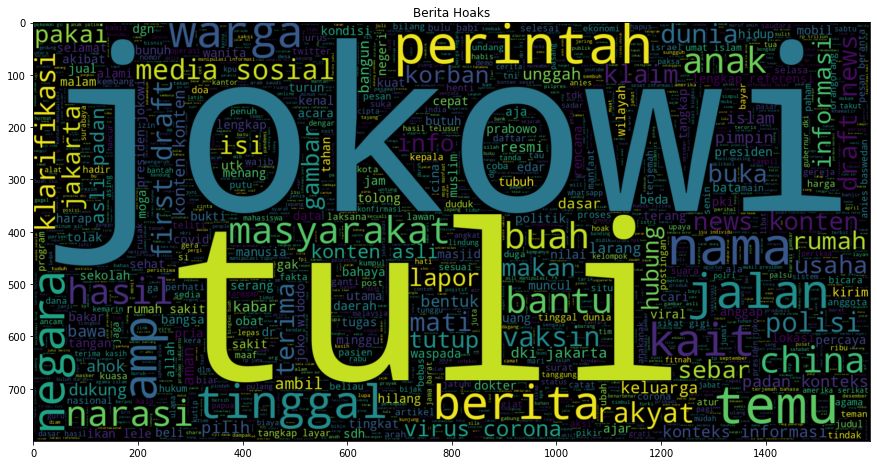

In [53]:
# visualisasi berita hoaks
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(narasi.loc[narasi.label == 'hoaks', 'content']))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Berita Hoaks")
plt.show()

#### Tokenizing

In [54]:
konten = " ".join(narasi['content'].values.tolist())
konten[-500:], len(konten)

('us intel bbrp kodamdi bbrp daerah jabar jakarta utama solotercium plot gera massa provokasi bbrp oknum grup kopassus loyal thd prabowomohon waspadapanglima kapolri sdh info intelijen inimakanya kapolri sdh perintah tembak dik joko widodo kuliah aja sy bangun tol hutama karya jd klo nerusin tol bpk bangun dik jokowi krna pembnguann lekat hati rakyat almarhum hm soeharto bkn ayo kmbali dukung no prabowo sandi perhati anggota info keluarga kerabat serangga sentuh thailand temu serangga myanmar temu',
 9035527)

In [55]:
konten = clean_text(konten) # clean text
konten_tokens = word_tokenize(konten) # tokenizing
# frekuensi kata
freq_konten = nltk.FreqDist(konten_tokens)
print(freq_konten.most_common(50))

[('presiden', 7272), ('perintah', 6173), ('jokowi', 5917), ('negara', 5655), ('masyarakat', 5066), ('jakarta', 4110), ('menteri', 3920), ('partai', 3804), ('milu', 3771), ('kait', 3644), ('hasil', 3640), ('jalan', 3494), ('kota', 3403), ('informasi', 3188), ('ketua', 3078), ('tni', 3007), ('nama', 2893), ('sehat', 2888), ('pilih', 2841), ('hukum', 2833), ('jabat', 2824), ('persen', 2817), ('terima', 2816), ('atur', 2807), ('kepala', 2798), ('bangun', 2764), ('warga', 2716), ('temu', 2666), ('politik', 2616), ('rumah', 2598), ('tinggal', 2562), ('anak', 2558), ('berita', 2516), ('tulis', 2513), ('dasar', 2502), ('dunia', 2484), ('daerah', 2454), ('dukung', 2421), ('media', 2395), ('anggota', 2356), ('tingkat', 2351), ('nomor', 2338), ('uang', 2300), ('sosial', 2291), ('buah', 2284), ('polisi', 2278), ('dpr', 2276), ('tahan', 2227), ('rakyat', 2191), ('edar', 2158)]


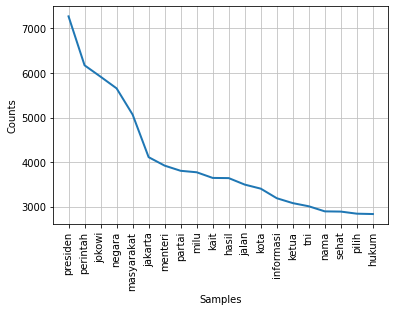

In [56]:
freq_konten.plot(20)

## Data Preprocessing

In [57]:
# masukkan statistik EDA ke dataframe utama
narasi = narasi[['content', 'upper', 'lower', 'punctuation', 'hastags', 'numerics', 'word_count', 'char_count', 'avg_word']]
berita = pd.concat([berita, narasi], axis=1)
# del berita['narasi']
berita.head()

,judul,narasi,label,content,upper,lower,punctuation,hastags,numerics,word_count,char_count,avg_word
0,Update: Hari Ini Positif Covid-19 Bertambah 24...,Kasus positif Covid-19 di Indonesia pada Min...,tepercaya,update positif positif minggu maret akumulasi ...,2,85,55,0,7,118,778,5.6
1,"Prabowo Terlempar dari 3 Besar, Sandiaga Uno C...",Menteri Pertahanan (Menhan) yang juga Ketua Um...,tepercaya,prabowo lempar sandiaga uno capres charming me...,11,349,183,0,13,508,3226,5.4
2,2 Penyebab Puan Maharani Selalu di Urutan Terb...,Ketua DPR RI Puan Maharani konsisten menjadi...,tepercaya,puan maharani urut survei capres ketua dpr ri ...,6,342,86,0,9,449,2870,5.4
3,Dave Laksono Sarankan Indonesia Ambil Inisiati...,Ukraina mengirim surat terbuka untuk Indonesia...,tepercaya,dave laksono saran ambil inisiatif damai rusia...,4,201,51,0,2,269,1697,5.3
4,Dubes Ukraina Tulis Surat Terbuka untuk Jokowi...,Duta Besar Ukraina Dr Vasyl Hamianin menulis...,tepercaya,dubes ukraina tulis surat buka jokowi mulia di...,2,583,120,0,1,773,4915,5.4


In [58]:
# menyortir berita yang hanya memiliki lebih dari atau sama dengna 70 kata
# referensi: https://twitter.com/ivanlanin/status/1380566912829071361
berita = berita[berita.word_count >= 70]

In [59]:
berita.describe()

,upper,lower,punctuation,hastags,numerics,word_count,char_count,avg_word
count,6559.000000,6559.000000,6559.000000,6559.000000,6559.000000,6559.000000,6559.000000,6559.000000
mean,13.181583,212.521421,70.312395,0.183412,4.804848,306.132185,1917.541698,5.235371
std,23.425610,195.327874,60.995356,1.489741,6.337107,257.403028,1623.253516,0.296892
min,0.000000,0.000000,2.000000,0.000000,0.000000,70.000000,339.000000,2.100000
25%,3.000000,93.000000,34.000000,0.000000,1.000000,142.000000,875.000000,5.100000
50%,8.000000,169.000000,56.000000,0.000000,3.000000,249.000000,1555.000000,5.200000
75%,17.000000,262.000000,85.000000,0.000000,6.000000,377.000000,2379.000000,5.400000
max,1339.000000,4023.000000,905.000000,62.000000,85.000000,4524.000000,28415.000000,8.900000


In [60]:
# split data
X = berita.content
y = berita['label'].replace(('hoaks', 'tepercaya'), (1, 0))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 3) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 3)
print('Jumlah data train:', X_train.shape[0])
print('Jumlah data test:', X_test.shape[0])
print('Jumlah data validation:', X_val.shape[0])

Jumlah data train: 4197
Jumlah data test: 1312
Jumlah data validation: 1050


In [61]:
y_train.value_counts(), y_test.value_counts(), y_val.value_counts()

(0    2402
 1    1795
 Name: label, dtype: int64,
 0    743
 1    569
 Name: label, dtype: int64,
 0    611
 1    439
 Name: label, dtype: int64)

In [62]:
# perkiraan jumlah kosa kata
kosa_kata = len(set(X_train.str.cat(sep=' ').split()))
print("Jumlah kosa kata:", kosa_kata)

Jumlah kosa kata: 40724


In [63]:
# jumlah kata terbanyak dalam satu data
maks_kata = X_train.str.split().str.len().max()
print("Jumlah kata terbanyak dalams satu berita:", maks_kata)

Jumlah kata terbanyak dalams satu berita: 1846


In [64]:
# setup text vect
max_vocab_length = 10000
max_length = 300

text_vectorization = TextVectorization(max_tokens=max_vocab_length,
                                       standardize=None,
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode='int',
                                       output_sequence_length=max_length)
text_vectorization.adapt(X_train)

2022-03-08 23:09:39.007841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 23:09:39.115656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 23:09:39.116917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 23:09:39.120105: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [65]:
# jumlah kosa kata setelah tokenisasi
print("Jumlah kosa kata setelah tokenisasi:", len(text_vectorization.get_vocabulary()))

Jumlah kosa kata setelah tokenisasi: 10000


### Create input data for pipeline

In [66]:
def df_to_dataset(features, labels, shuffle=True, batch_size=32):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(features))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

train_ds = df_to_dataset(X_train, y_train, batch_size=256)
val_ds = df_to_dataset(X_val, y_val, shuffle=False, batch_size=256)
test_ds = df_to_dataset(X_test, y_test, shuffle=False, batch_size=256)

## Model

In [67]:
# membuat dataframe untuk membandingkan hasil setiap model
results_df = pd.DataFrame(
    columns=['F1 Score', 'Accuracy'],
    index=['Dummy Classifier', 'Naive Bayes', 'DL Model 1', 'DL Model 2 LSTM', 'DL Model 3 GRU']
)
results_df

,F1 Score,Accuracy
Dummy Classifier,NaN,NaN
Naive Bayes,NaN,NaN
DL Model 1,NaN,NaN
DL Model 2 LSTM,NaN,NaN
DL Model 3 GRU,NaN,NaN


In [68]:
# fungsi melakukan training pada model dan hasilnya
def modeling(Model, Xtrain, Xtest):
    model = Model
    model.fit(Xtrain, y_train)
    y_pred = model.predict(Xtest)
    return y_pred

# fungsi membuat confusion matrix
def conf_matrix(model_names, y_test, y_pred):
    plt.figure(figsize=(6, 6))
    plt.title(f'Confusion Matrix of {model_names}')
    ax = plt.subplot()
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g', cmap=plt.cm.Blues)
    ax.set_xlabel('Label Prediksi')
    ax.set_ylabel('Label Aktual')
    plt.show()

# fungsi menunjukkan hasil pelatihan model
def model_results(names, y_pred, y_test=y_test):
    score = f1_score(y_test, y_pred)
    accscore = accuracy_score(y_test, y_pred)
    results_df.loc[names, 'F1 Score'] = score
    results_df.loc[names, 'Accuracy'] = accscore
    
    print(f'----------   {names}   ----------')
    print("f1 score:", score)
    print("acc score:", accscore)
    print()
    conf_matrix(names, y_test, y_pred)
    print()
    print('Classification Report')
    print(classification_report(y_test, y_pred))

### Baseline Model

In [69]:
# Dummy Classifier
dummy_clf = DummyClassifier(strategy = 'stratified', random_state = 3)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
f1score = f1_score(y_test, y_pred)
accscore = accuracy_score(y_test, y_pred)
results_df.loc['Dummy Classifier', 'F1 Score'] = f1score
results_df.loc['Dummy Classifier', 'Accuracy'] = accscore
    
# Printing evaluation metric (f1-score) 
print("f1 score:", f1score)
print("accuracy score:", accscore)
print()
print('Classification Report')
print(classification_report(y_test, y_pred))

f1 score: 0.45614035087719296
accuracy score: 0.5274390243902439

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.58      0.58       743
           1       0.46      0.46      0.46       569

    accuracy                           0.53      1312
   macro avg       0.52      0.52      0.52      1312
weighted avg       0.53      0.53      0.53      1312



### Naive Bayes

----------   Naive Bayes   ----------
f1 score: 0.8482816429170159
acc score: 0.8620426829268293



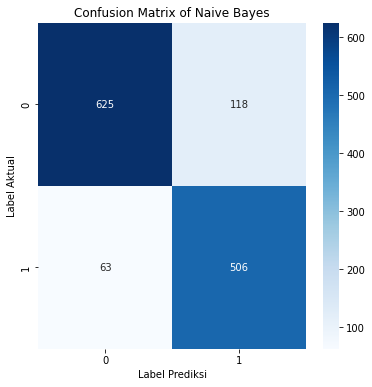


Classification Report
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       743
           1       0.81      0.89      0.85       569

    accuracy                           0.86      1312
   macro avg       0.86      0.87      0.86      1312
weighted avg       0.87      0.86      0.86      1312



In [70]:
# Naive Bayes
mnb = MultinomialNB()
vect = CountVectorizer()
X_train_vec = vect.fit_transform(X_train)
X_test_vec = vect.transform(X_test)

model_results('Naive Bayes', modeling(mnb, X_train_vec, X_test_vec))

### Deep Learning

In [71]:
embedding = Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length)

#### Model 1 - GlobalAveregePooling

In [72]:
# deep learning model 1
inputs = Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(1, activation='sigmoid')(x)

model_1 = Model(inputs, outputs, name="GAPooling_model")
model_1.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=["accuracy"])
model_1.summary()

Model: "GAPooling_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 128)          1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [73]:
model_1_hist = model_1.fit(train_ds, epochs=100, validation_data=val_ds)

Epoch 1/100
17/17 [==============================] - 2s 23ms/step - loss: 0.6839 - accuracy: 0.6614 - val_loss: 0.6735 - val_accuracy: 0.7400
Epoch 2/100
17/17 [==============================] - 0s 23ms/step - loss: 0.6603 - accuracy: 0.7675 - val_loss: 0.6493 - val_accuracy: 0.7476
Epoch 3/100
17/17 [==============================] - 0s 18ms/step - loss: 0.6313 - accuracy: 0.7891 - val_loss: 0.6194 - val_accuracy: 0.7810
Epoch 4/100
17/17 [==============================] - 0s 14ms/step - loss: 0.5979 - accuracy: 0.8058 - val_loss: 0.5863 - val_accuracy: 0.7905
Epoch 5/100
17/17 [==============================] - 0s 14ms/step - loss: 0.5620 - accuracy: 0.8127 - val_loss: 0.5514 - val_accuracy: 0.8114
Epoch 6/100
17/17 [==============================] - 0s 13ms/step - loss: 0.5257 - accuracy: 0.8342 - val_loss: 0.5173 - val_accuracy: 0.8229
Epoch 7/100
17/17 [==============================] - 0s 14ms/step - loss: 0.4915 - accuracy: 0.8449 - val_loss: 0.4860 - val_accuracy: 0.8295
Epoch 

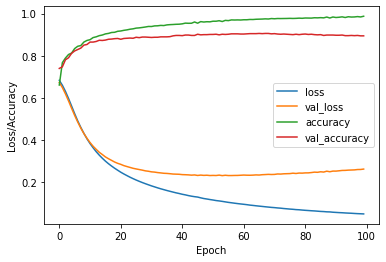

In [74]:
metrics = pd.DataFrame(model_1_hist.history)
metrics[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot()
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.show()

----------   DL Model 1   ----------
f1 score: 0.8770764119601329
acc score: 0.8942857142857142



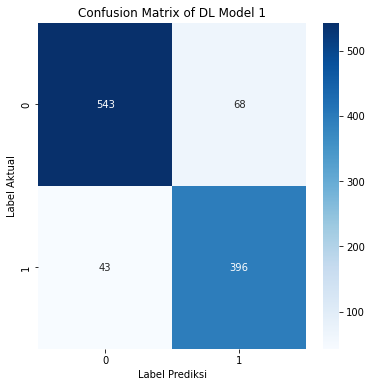


Classification Report
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       611
           1       0.85      0.90      0.88       439

    accuracy                           0.89      1050
   macro avg       0.89      0.90      0.89      1050
weighted avg       0.90      0.89      0.89      1050



In [75]:
yval_pred = model_1.predict(X_val)
model_results('DL Model 1', np.round(yval_pred), y_val)

----------   DL Model 3 GRU   ----------
f1 score: 0.8762886597938143
acc score: 0.8902439024390244



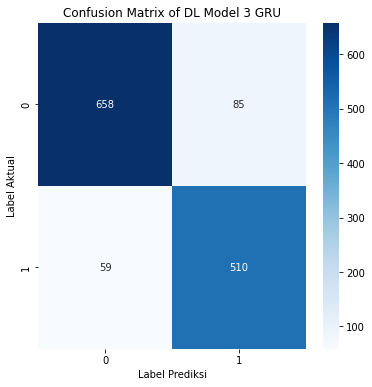


Classification Report
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       743
           1       0.86      0.90      0.88       569

    accuracy                           0.89      1312
   macro avg       0.89      0.89      0.89      1312
weighted avg       0.89      0.89      0.89      1312



In [76]:
ytest_pred = model_1.predict(X_test)
model_results('DL Model 3 GRU', np.round(ytest_pred), y_test)

#### Model 2 - LSTM

In [77]:
# deep learning model 2 - LSTM
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding(x)
x = LSTM(64)(x)
outputs = Dense(1, activation='sigmoid')(x)
                                         
model_2 = Model(inputs, outputs, name="LSTM_model")
model_2.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=["accuracy"])
model_2.summary()

Model: "LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 128)          1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [78]:
model_2_hist = model_2.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50


2022-03-08 23:10:26.578009: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


17/17 [==============================] - 3s 57ms/step - loss: 0.6647 - accuracy: 0.5778 - val_loss: 0.6636 - val_accuracy: 0.6124
Epoch 2/50
17/17 [==============================] - 1s 33ms/step - loss: 0.3904 - accuracy: 0.8344 - val_loss: 0.4253 - val_accuracy: 0.8562
Epoch 3/50
17/17 [==============================] - 1s 34ms/step - loss: 0.1411 - accuracy: 0.9666 - val_loss: 0.4891 - val_accuracy: 0.8743
Epoch 4/50
17/17 [==============================] - 1s 34ms/step - loss: 0.1711 - accuracy: 0.9585 - val_loss: 0.4386 - val_accuracy: 0.8781
Epoch 5/50
17/17 [==============================] - 1s 34ms/step - loss: 0.1494 - accuracy: 0.9638 - val_loss: 0.4123 - val_accuracy: 0.8790
Epoch 6/50
17/17 [==============================] - 1s 34ms/step - loss: 0.1425 - accuracy: 0.9671 - val_loss: 0.4464 - val_accuracy: 0.8781
Epoch 7/50
17/17 [==============================] - 1s 34ms/step - loss: 0.1547 - accuracy: 0.9628 - val_loss: 0.4681 - val_accuracy: 0.8686
Epoch 8/50
17/17 [======

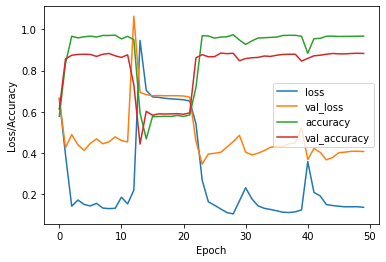

In [79]:
metrics = pd.DataFrame(model_2_hist.history)
metrics[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot()
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.show()

----------   DL Model 2 LSTM   ----------
f1 score: 0.8681672025723471
acc score: 0.8828571428571429



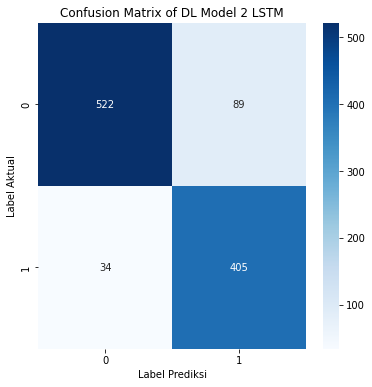


Classification Report
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       611
           1       0.82      0.92      0.87       439

    accuracy                           0.88      1050
   macro avg       0.88      0.89      0.88      1050
weighted avg       0.89      0.88      0.88      1050



In [80]:
yval_pred = model_2.predict(X_val)
model_results('DL Model 2 LSTM', np.round(yval_pred), y_val)

#### Model 3 - GRU

In [81]:
# deep learning model 3 - GRU
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding(x)
x = GRU(64)(x)
outputs = Dense(1, activation='sigmoid')(x)
                                         
model_3 = Model(inputs, outputs, name="GRU_model")
model_3.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=["accuracy"])
model_3.summary()

Model: "GRU_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 128)          1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [82]:
model_3_hist = model_3.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
17/17 [==============================] - 2s 62ms/step - loss: 0.6643 - accuracy: 0.5790 - val_loss: 0.6805 - val_accuracy: 0.6067
Epoch 2/50
17/17 [==============================] - 1s 39ms/step - loss: 0.6428 - accuracy: 0.5945 - val_loss: 0.6766 - val_accuracy: 0.6105
Epoch 3/50
17/17 [==============================] - 1s 32ms/step - loss: 0.6345 - accuracy: 0.5940 - val_loss: 0.7582 - val_accuracy: 0.4695
Epoch 4/50
17/17 [==============================] - 1s 32ms/step - loss: 0.6871 - accuracy: 0.5116 - val_loss: 0.7128 - val_accuracy: 0.4619
Epoch 5/50
17/17 [==============================] - 1s 32ms/step - loss: 0.6391 - accuracy: 0.5189 - val_loss: 0.6752 - val_accuracy: 0.6076
Epoch 6/50
17/17 [==============================] - 1s 32ms/step - loss: 0.6221 - accuracy: 0.6047 - val_loss: 0.6633 - val_accuracy: 0.6114
Epoch 7/50
17/17 [==============================] - 1s 32ms/step - loss: 0.6154 - accuracy: 0.6061 - val_loss: 0.6617 - val_accuracy: 0.6133
Epoch 8/50
17

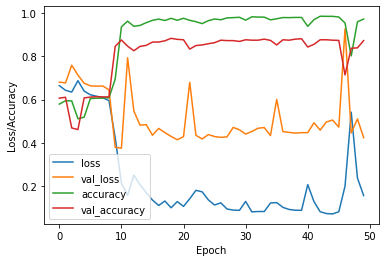

In [83]:
metrics = pd.DataFrame(model_3_hist.history)
metrics[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot()
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.show()

----------   DL Model 3 GRU   ----------
f1 score: 0.8457142857142859
acc score: 0.8714285714285714



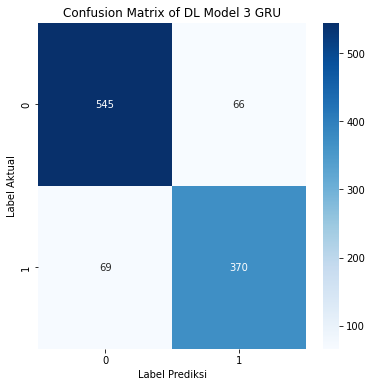


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       611
           1       0.85      0.84      0.85       439

    accuracy                           0.87      1050
   macro avg       0.87      0.87      0.87      1050
weighted avg       0.87      0.87      0.87      1050



In [84]:
yval_pred = model_3.predict(X_val)
model_results('DL Model 3 GRU', np.round(yval_pred), y_val)

### Hasil Semua Model

In [85]:
results_df

,F1 Score,Accuracy
Dummy Classifier,0.45614,0.527439
Naive Bayes,0.848282,0.862043
DL Model 1,0.877076,0.894286
DL Model 2 LSTM,0.868167,0.882857
DL Model 3 GRU,0.845714,0.871429


### Model Tuning

In [86]:
# deep learning model 2 - LSTM
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding(x)
x = LSTM(128, return_sequences = True)(x)
x = LSTM(64)(x)
x = Dense(32, activation = 'relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
                                         
model_2t = Model(inputs, outputs, name="LSTM_model")
model_2t.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.01), metrics=["accuracy"])
model_2t.summary()

Model: "LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 128)          1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 128)          131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3

In [87]:
model_2t_hist = model_2t.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
17/17 [==============================] - 4s 102ms/step - loss: 0.7477 - accuracy: 0.5690 - val_loss: 0.6545 - val_accuracy: 0.6200
Epoch 2/50
17/17 [==============================] - 1s 67ms/step - loss: 0.6500 - accuracy: 0.6100 - val_loss: 0.5896 - val_accuracy: 0.7048
Epoch 3/50
17/17 [==============================] - 1s 66ms/step - loss: 0.4440 - accuracy: 0.8099 - val_loss: 0.6347 - val_accuracy: 0.7495
Epoch 4/50
17/17 [==============================] - 1s 67ms/step - loss: 0.4061 - accuracy: 0.8482 - val_loss: 0.5428 - val_accuracy: 0.7933
Epoch 5/50
17/17 [==============================] - 1s 67ms/step - loss: 0.3606 - accuracy: 0.8880 - val_loss: 0.5294 - val_accuracy: 0.8162
Epoch 6/50
17/17 [==============================] - 1s 67ms/step - loss: 0.3284 - accuracy: 0.8961 - val_loss: 0.5006 - val_accuracy: 0.8162
Epoch 7/50
17/17 [==============================] - 1s 67ms/step - loss: 0.3280 - accuracy: 0.8966 - val_loss: 0.5102 - val_accuracy: 0.8181
Epoch 8/50
1

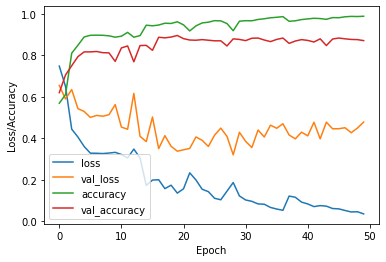

In [88]:
metrics = pd.DataFrame(model_2t_hist.history)
metrics[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot()
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.show()

----------   DL Model 2 LSTM   ----------
f1 score: 0.8495575221238939
acc score: 0.8704761904761905



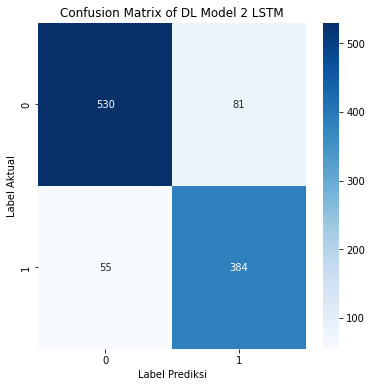


Classification Report
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       611
           1       0.83      0.87      0.85       439

    accuracy                           0.87      1050
   macro avg       0.87      0.87      0.87      1050
weighted avg       0.87      0.87      0.87      1050



In [89]:
yval_pred = model_2t.predict(X_val)
model_results('DL Model 2 LSTM', np.round(yval_pred), y_val)

In [90]:
# deep learning model 3 - GRU
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding(x)
x = GRU(128, return_sequences = True)(x)
x = GRU(64)(x)
x = Dense(32, activation = 'relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
                                         
model_3t = Model(inputs, outputs, name="GRU_model")
model_3t.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])
model_3t.summary()

Model: "GRU_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 128)          1280000   
_________________________________________________________________
gru_1 (GRU)                  (None, 300, 128)          99072     
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33

In [91]:
model_3t_hist = model_3t.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
17/17 [==============================] - 4s 96ms/step - loss: 0.6971 - accuracy: 0.5659 - val_loss: 0.5068 - val_accuracy: 0.8038
Epoch 2/50
17/17 [==============================] - 1s 63ms/step - loss: 0.4183 - accuracy: 0.8506 - val_loss: 0.3980 - val_accuracy: 0.8248
Epoch 3/50
17/17 [==============================] - 1s 63ms/step - loss: 0.1843 - accuracy: 0.9328 - val_loss: 0.3445 - val_accuracy: 0.8867
Epoch 4/50
17/17 [==============================] - 1s 63ms/step - loss: 0.0665 - accuracy: 0.9778 - val_loss: 0.4933 - val_accuracy: 0.8724
Epoch 5/50
17/17 [==============================] - 1s 63ms/step - loss: 0.1186 - accuracy: 0.9526 - val_loss: 0.4397 - val_accuracy: 0.8705
Epoch 6/50
17/17 [==============================] - 1s 63ms/step - loss: 0.0426 - accuracy: 0.9852 - val_loss: 0.4139 - val_accuracy: 0.8829
Epoch 7/50
17/17 [==============================] - 1s 63ms/step - loss: 0.0256 - accuracy: 0.9902 - val_loss: 0.4847 - val_accuracy: 0.8790
Epoch 8/50
17

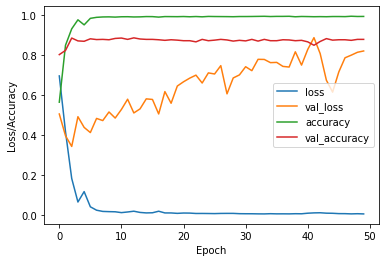

In [92]:
metrics = pd.DataFrame(model_3t_hist.history)
metrics[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot()
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.show()

----------   DL Model 3 GRU   ----------
f1 score: 0.8545034642032333
acc score: 0.88



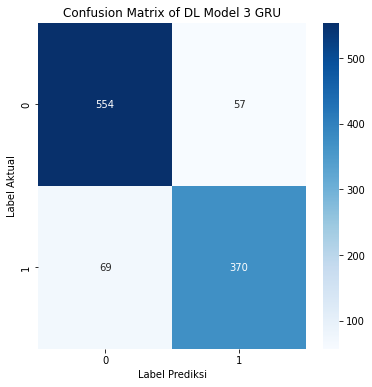


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       611
           1       0.87      0.84      0.85       439

    accuracy                           0.88      1050
   macro avg       0.88      0.87      0.88      1050
weighted avg       0.88      0.88      0.88      1050



In [93]:
yval_pred = model_3t.predict(X_val)
model_results('DL Model 3 GRU', np.round(yval_pred), y_val)

In [94]:
# deep learning model 1
inputs = Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = GRU(128, return_sequences = True)(x)
x = LSTM(64, return_sequences = True)(x)
x = GlobalAveragePooling1D()(x)
x = Dense(32, activation = 'relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model_1t = Model(inputs, outputs, name="GAPooling_model")
model_1t.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=["accuracy"])
model_1t.summary()

Model: "GAPooling_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 128)          1280000   
_________________________________________________________________
gru_3 (GRU)                  (None, 300, 128)          99072     
_________________________________________________________________
lstm_3 (LSTM)                (None, 300, 64)           49408     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)            

In [95]:
model_1t_hist = model_1t.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
17/17 [==============================] - 4s 110ms/step - loss: 0.3990 - accuracy: 0.9195 - val_loss: 0.2937 - val_accuracy: 0.8829
Epoch 2/50
17/17 [==============================] - 1s 63ms/step - loss: 0.1171 - accuracy: 0.9638 - val_loss: 0.4187 - val_accuracy: 0.8733
Epoch 3/50
17/17 [==============================] - 1s 64ms/step - loss: 0.0743 - accuracy: 0.9764 - val_loss: 0.3664 - val_accuracy: 0.8876
Epoch 4/50
17/17 [==============================] - 1s 65ms/step - loss: 0.0574 - accuracy: 0.9824 - val_loss: 0.3744 - val_accuracy: 0.8867
Epoch 5/50
17/17 [==============================] - 1s 64ms/step - loss: 0.0482 - accuracy: 0.9836 - val_loss: 0.4037 - val_accuracy: 0.8790
Epoch 6/50
17/17 [==============================] - 1s 64ms/step - loss: 0.0372 - accuracy: 0.9871 - val_loss: 0.4136 - val_accuracy: 0.8800
Epoch 7/50
17/17 [==============================] - 1s 63ms/step - loss: 0.0325 - accuracy: 0.9878 - val_loss: 0.4234 - val_accuracy: 0.8876
Epoch 8/50
1

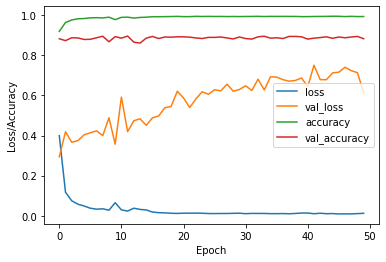

In [96]:
metrics = pd.DataFrame(model_1t_hist.history)
metrics[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot()
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.show()

----------   DL Model 3 GRU   ----------
f1 score: 0.8584579976985041
acc score: 0.8828571428571429



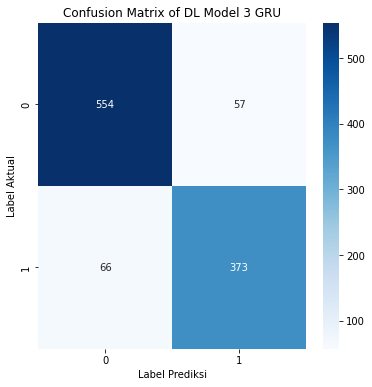


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       611
           1       0.87      0.85      0.86       439

    accuracy                           0.88      1050
   macro avg       0.88      0.88      0.88      1050
weighted avg       0.88      0.88      0.88      1050



In [97]:
yval_pred = model_1t.predict(X_val)
model_results('DL Model 3 GRU', np.round(yval_pred), y_val)

----------   DL Model 3 GRU   ----------
f1 score: 0.8586762075134168
acc score: 0.8795731707317073



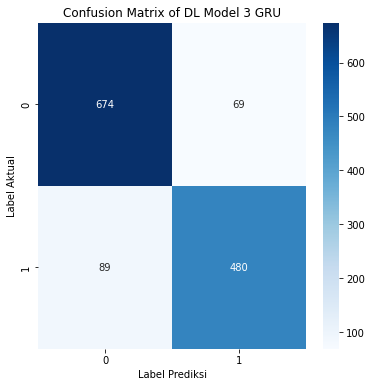


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       743
           1       0.87      0.84      0.86       569

    accuracy                           0.88      1312
   macro avg       0.88      0.88      0.88      1312
weighted avg       0.88      0.88      0.88      1312



In [98]:
ytest_pred = model_1t.predict(X_test)
model_results('DL Model 3 GRU', np.round(ytest_pred), y_test)

In [99]:
# save model terbaik
model_1.save('prediksi_hoaks')

2022-03-08 23:15:36.329387: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
